In [ ]:
* https://aws-samples.github.io/amazon-textract-textractor/notebooks/tabular_data_linearization_continued.html#

# Tabular Data Extraction with Amazon Textract

In this notebook, we'll explore how to extract and analyze tabular data from documents using Amazon Textract. We'll also demonstrate how to visualize and process the extracted data using Python.

## 1. Introduction to Tabular Data Extraction

Amazon Textract is a powerful service that automatically extracts text, handwriting, and data from scanned documents, including tables and forms. This makes it an essential tool for processing structured and semi-structured data. The `amazon-textract-textractor` library simplifies interaction with Textract's output, providing easy-to-use interfaces for handling complex data.

## 2. Setting Up the Environment

First, we need to install the necessary Python packages. We'll be using `boto3` for AWS interaction and `amazon-textract-textractor` for processing the Textract output.




In [57]:
!pip install boto3 amazon-textract-textractor


## 3. Loading and Processing the Image

Next, we'll load the image that contains the tabular data and send it to Textract for analysis.

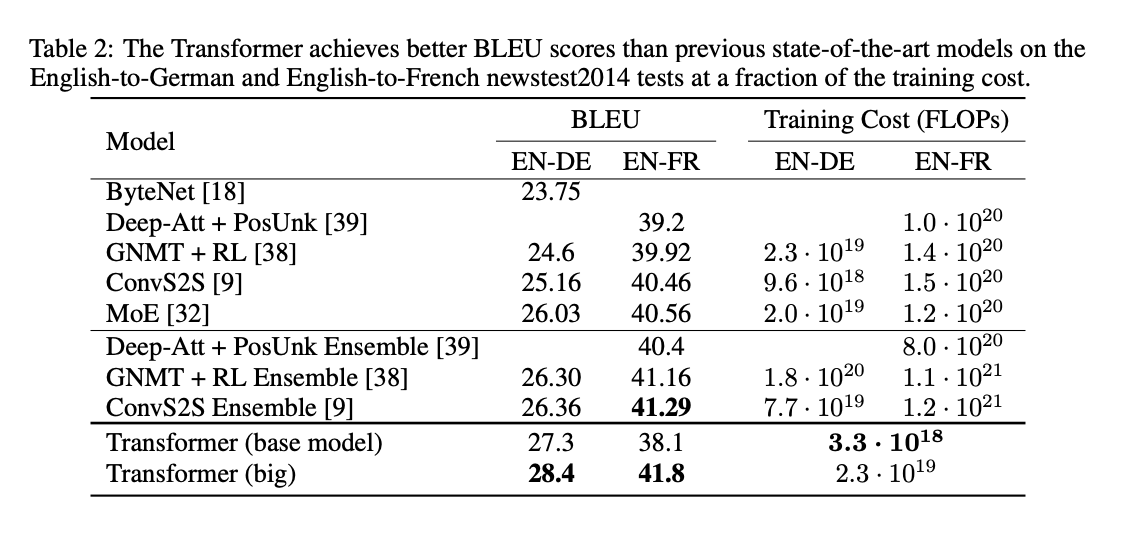

In [58]:
from PIL import Image
from textractor import Textractor
from textractor.data.constants import TextractFeatures

image_path = "./data/images/table_attention_2.png"
image = Image.open(image_path)

image

In [91]:
extractor = Textractor()
document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.TABLES],
    save_image=True
)

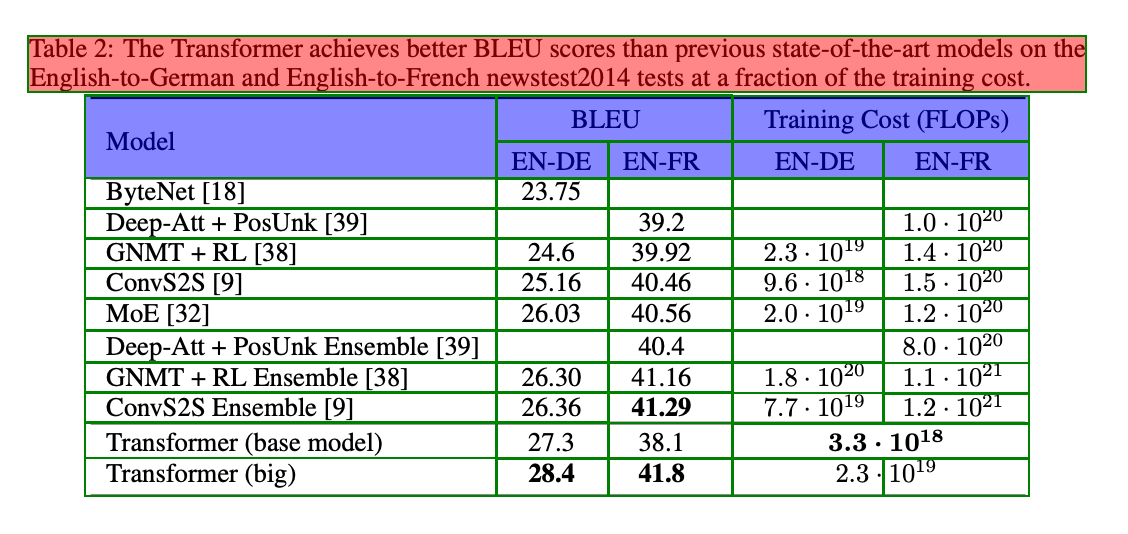

In [92]:
document.tables[0].visualize(with_words=False)


## 4. Extracting and Displaying Table Data in Markdown

We can extract the table data in a readable format, such as Markdown, and display it within the notebook.

In [46]:
from textractor.data.text_linearization_config import TextLinearizationConfig
from IPython.display import display, Markdown

table_markdown = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown'))
display(Markdown(table_markdown))

| Model                           | BLEU    |       | Training Cost (FLOPs)    |          |
|---------------------------------|---------|-------|--------------------------|----------|
|                                 | EN-DE   | EN-FR | EN-DE                    | EN-FR    |
| ByteNet [18]                    | 23.75   |       |                          |          |
| Deep-Att + PosUnk [39]          |         | 39.2  |                          | 1.0 1020 |
| GNMT + RL [38]                  | 24.6    | 39.92 | 2.3 1019                 | 1.4 1020 |
| ConvS2S [9]                     | 25.16   | 40.46 | 9.6 1018                 | 1.5 1020 |
| MoE [32]                        | 26.03   | 40.56 | 2.0 . 1019               | 1.2 1020 |
| Deep-Att + PosUnk Ensemble [39] |         | 40.4  |                          | 8.0 1020 |
| GNMT + RL Ensemble [38]         | 26.30   | 41.16 | 1.8 1020                 | 1.1 1021 |
| ConvS2S Ensemble [9]            | 26.36   | 41.29 | 7.7 . 1019               | 1.2 1021 |
| Transformer (base model)        | 27.3    | 38.1  | 3.3 . 1018               |          |
| Transformer (big)               | 28.4    | 41.8  | 2.3 .                    | 1019     |

The above is a table in the markdown format, we can paste in in a new cell to see it rendered properly. It might be necessary to set table_column_header_threshold=0.5 otherwise the top row would not be identified as a header, due to the first cell that might not be a header itself (this was not the case). table_column_header_threshold is a threshold for a row to be selected as header when rendering as markdown. 0.5 means that 50% of the cells must have the is_header_cell flag. For more details see https://aws-samples.github.io/amazon-textract-textractor/textractor.data.text_linearization_config.html.

Markdown does not support merged cells. This is problematic as we see that the “EN-FR” column is not associated to BLEU or Training Cost, as it simply appears without headers. Let’s test Q&A on tabular data with an LLM.


## 5. Q&A on tabular data with LLM

Firstly, we can try to run our LLM query on the raw tabular data, then we'll use the markdown format, as previously displayed, lastly we'll configure the markdown to replicate the content in merged cells and we'll compare the results.

Our test question is: "Which is the cost for the GNMT + RL in English-French?"

And the correct answer would be  $1.4\cdot10^{20}$.


In [146]:
import json
import boto3
import os

# Util function to get response from Bedrock

import boto3, json

session = boto3.Session()
bedrock = session.client(service_name='bedrock-runtime')

question = "Which is the cost for the GNMT + RL in English-French?"

def get_response_from_bedrock(context, question):
    
    message_list = []

    initial_message = {
        "role": "user",
        "content": [
            { "text": f"Context: {context}"}, 
            { "text": f"Given the provided context, answer the question: {question}. If you don't know the answer, just mention you don't know." } 
        ],
    }

    message_list.append(initial_message)

    response = bedrock.converse(
        modelId="anthropic.claude-v2:1", # Try to change with more recently released models e.g. "anthropic.claude-3-haiku-20240307-v1:0",
        messages=message_list,
        inferenceConfig={
            "maxTokens": 2000,
            "temperature": 0,
        },
    )

    return response['output']['message']['content'][0]['text']
    


### Q&A on raw text


In [152]:
raw_text = document.get_text()

response_raw_text = get_response_from_bedrock(raw_text, question)

We see that the model using raw text gives **the wrong answer**. 

### Q&A on markdown text

In [153]:
response_standard_markdown = get_response_from_bedrock(table_markdown, question)

We see that the model using standard markdown text is **unable to extract the correct answer**. 

### Q&A on normalised markdown text

We can change the TextLinearizationConfig to duplicate text in merged cells, so that we'll get twice BLEU and Training Cost columns:


In [149]:
markdown_normalized_table = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown', table_duplicate_text_in_merged_cells=True))

display(Markdown(markdown_normalized_table))

| Model                           | BLEU    | BLEU    | Training Cost (FLOPs)    | Training Cost (FLOPs)    |
|---------------------------------|---------|---------|--------------------------|--------------------------|
| Model                           | EN-DE   | EN-FR   | EN-DE                    | EN-FR                    |
| ByteNet [18]                    | 23.75   |         |                          |                          |
| Deep-Att + PosUnk [39]          |         | 39.2    |                          | 1.0 1020                 |
| GNMT + RL [38]                  | 24.6    | 39.92   | 2.3 1019                 | 1.4 1020                 |
| ConvS2S [9]                     | 25.16   | 40.46   | 9.6 1018                 | 1.5 1020                 |
| MoE [32]                        | 26.03   | 40.56   | 2.0 . 1019               | 1.2 1020                 |
| Deep-Att + PosUnk Ensemble [39] |         | 40.4    |                          | 8.0 1020                 |
| GNMT + RL Ensemble [38]         | 26.30   | 41.16   | 1.8 1020                 | 1.1 1021                 |
| ConvS2S Ensemble [9]            | 26.36   | 41.29   | 7.7 . 1019               | 1.2 1021                 |
| Transformer (base model)        | 27.3    | 38.1    | 3.3 . 1018               | 3.3 . 1018               |
| Transformer (big)               | 28.4    | 41.8    | 2.3 .                    | 1019                     |

In [154]:
response_normalised_markdown = get_response_from_bedrock(markdown_normalized_table, question)

We see that the model using normalised markdown text gives **the correct answer**. 

## Conclusions

By leveraging Textract Tables, we can build a better text representation of the tabular data, leading to a better performance in question answering tasks. 

Let's have a look at the 3 answers:

In [170]:
import pandas as pd
from IPython.display import display, HTML

data = {
    "Raw Text": [response_raw_text, "Wrong answer"],
    "Standard Markdown": [response_standard_markdown, "Missing answer"],
    "Normalised Markdown": [response_normalised_markdown, "Correct answer"]
}

df = pd.DataFrame(data)

question_html = f"<em>{question}</em>"
html = f"<h4>{question_html}</h4>"
html += df.to_html(index=False, escape=False)  
display(HTML(html))

Raw Text,Standard Markdown,Normalised Markdown
"Based on the table, the training cost (FLOPs) for GNMT + RL in English-French is 1.1 1021.","Unfortunately, I do not know the cost for the GNMT + RL in English-French. The table does not provide that information. It shows the training cost (FLOPs) for GNMT + RL in English-German as 2.3 1019, but there is no data listed for GNMT + RL in English-French. So I would have to admit that I don't have enough information to answer this specific question.","Based on the table, the training cost (FLOPs) for GNMT + RL in English-French is 1.4 1020."
Wrong answer,Missing answer,Correct answer
